In [1]:
import numpy as np
from ax import optimize
import matplotlib.pyplot as plt

In [15]:
from scipy.ndimage import label, find_objects
from ax.service.ax_client import AxClient, ObjectiveProperties

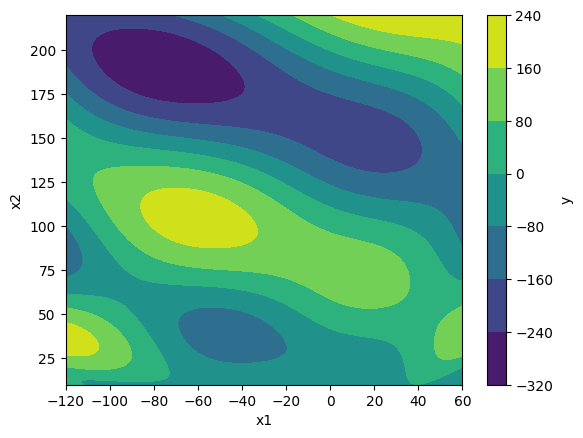

In [3]:
# define and plot a 2d objective function
def eggholder(x1, x2):
    term1 = -(x2 + 47) * np.sin(np.sqrt(np.abs(x2 + 0.5*x1 + 47)))
    term2 = -x1 * np.sin(np.sqrt(np.abs(x1-(x2+47))))
    return term1 + term2

# picked some limits that made a clear plot with multiple local minima not too close to edge
x1 = np.linspace(-120, 60, num=2001)
x2 = np.linspace(10, 220, num=2001)
X1, X2 = np.meshgrid(x1, x2)
y = eggholder(X1, X2)
# Create contour plot
conts = plt.contourf(X1, X2, y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label="y")
plt.show()

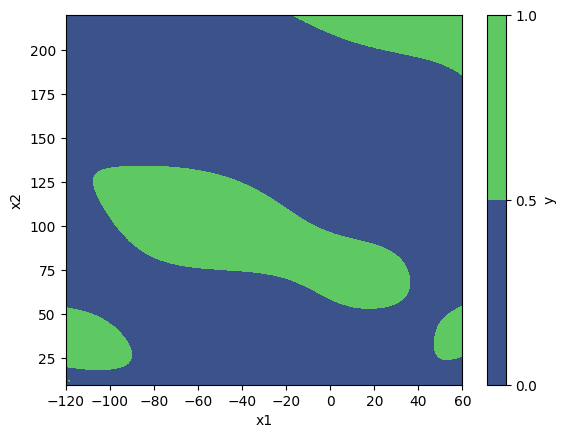

In [4]:
conts = plt.contourf(X1, X2, y>80)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label="y")
plt.show()

In [5]:
def find_regions(y, cutoff):
    labeled_array, num_features = label(y<cutoff)
    print(num_features)
    conts = plt.contourf(X1, X2, labeled_array)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.colorbar(label="y")
    plt.show()
    

2


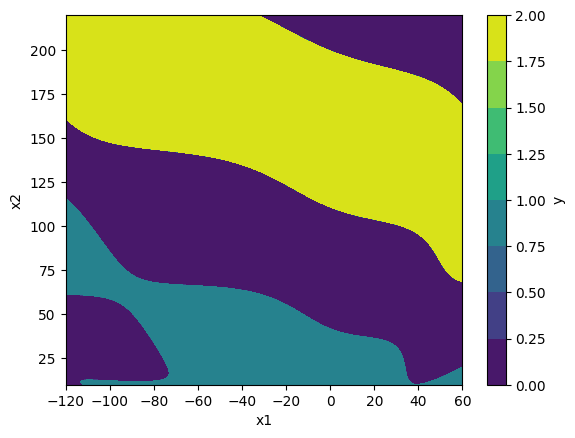

In [6]:
find_regions(y,0)

In [98]:
areas_labeled, num_features = label(y<0)

In [110]:
y[find_objects(areas_labeled)[0]]>0


array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])

In [106]:
def slice_to_bounds(s, map_to_val):

    dim_range = map_to_val[s]
    return (dim_range[0], dim_range[-1])
    


In [116]:
param_bounds = [{'x1':slice_to_bounds(slices[1], x1), 'x2': slice_to_bounds(slices[0], x2)} for slices in find_objects(areas_labeled)]
param_bounds

[{'x1': (-120.0, 60.0), 'x2': (10.0, 115.945)},
 {'x1': (-120.0, 60.0), 'x2': (68.695, 220.0)}]

In [113]:
for count, slices in enumerate(find_objects(areas_labeled)):
    area_id = count + 1
    print(area_id)
    
    sub_slices =find_objects(areas_labeled[slices]) 

    # print(sub_slices)
    overlap_slices = [s for n, s in enumerate(sub_slices) if n !=count] 
    # overlap_slices = [(n, s) for n, s in enumerate(sub_slices)] 
    print(overlap_slices)
    # print(areas_labeled[slices])

    bounds_dict = {'x1':slice_to_bounds(slices[1], x1), 'x2': slice_to_bounds(slices[0], x2)}
    param_constraints = []
    print(bounds_dict)


1
[(slice(559, 1010, None), slice(1237, 2001, None))]
{'x1': (-120.0, 60.0), 'x2': (10.0, 115.945)}
2
[(slice(0, 451, None), slice(0, 421, None))]
{'x1': (-120.0, 60.0), 'x2': (68.695, 220.0)}


In [118]:
ax_client = AxClient()

[INFO 07-01 18:01:40] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [123]:
ax_client.create_experiment(
    name="eggholder_test_experiment_1",
    parameters = [
        {
            "name": "x1",
            "type": "range",
            "bounds": [-120.0, 60.0],
            "value_type": "float"
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [10.0, 220.0],
            "value_type": "float"
        },

    ],
    objectives={"y": ObjectiveProperties(minimize=True)},
    choose_generation_strategy_kwargs={"num_initialization_trials": 20},
    overwrite_existing_experiment=True
)

[INFO 07-01 18:03:03] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[-120.0, 60.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[10.0, 220.0])], parameter_constraints=[]).
[INFO 07-01 18:03:03] ax.service.ax_client: Overwriting existing experiment (eggholder_test_experiment_1) on this client with new experiment (eggholder_test_experiment_1) and restarting the generation strategy.
[INFO 07-01 18:03:03] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 07-01 18:03:03] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=20 max_initialization_trials=None num_tunable_parameters=2 num_trials=None use_batch_trials=False
[INFO 07-01 18:03:03] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_re

In [124]:
for i in range(21):
    parameterization, trial_index = ax_client.get_next_trial()
    result = eggholder(parameterization['x1'], parameterization['x2'])
    ax_client.complete_trial(trial_index=trial_index, raw_data={'y':result})

[INFO 07-01 18:03:04] ax.service.ax_client: Generated new trial 0 with parameters {'x1': -117.432405, 'x2': 108.591759} using model Sobol.
[INFO 07-01 18:03:04] ax.service.ax_client: Completed trial 0 with data: {'y': (-22.371388, None)}.
[INFO 07-01 18:03:04] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 58.566752, 'x2': 55.048766} using model Sobol.
[INFO 07-01 18:03:04] ax.service.ax_client: Completed trial 1 with data: {'y': (73.321865, None)}.
[INFO 07-01 18:03:04] ax.service.ax_client: Generated new trial 2 with parameters {'x1': -57.951857, 'x2': 44.519948} using model Sobol.
[INFO 07-01 18:03:04] ax.service.ax_client: Completed trial 2 with data: {'y': (-110.737833, None)}.
[INFO 07-01 18:03:04] ax.service.ax_client: Generated new trial 3 with parameters {'x1': -105.781171, 'x2': 39.726338} using model Sobol.
[INFO 07-01 18:03:04] ax.service.ax_client: Completed trial 3 with data: {'y': (141.152159, None)}.
[INFO 07-01 18:03:04] ax.service.ax_client: Genera

In [135]:
ax_client.get_contour_plot()

[INFO 07-01 18:08:54] ax.service.ax_client: Retrieving contour plot with parameter 'x1' on X-axis and 'x2' on Y-axis, for metric 'y'. Remaining parameters are affixed to the middle of their range.


AxPlotConfig(data={'data': [{'autocolorscale': False, 'autocontour': True, 'colorbar': {'tickfont': {'size': 8}, 'ticksuffix': '', 'x': 0.45, 'y': 0.5}, 'colorscale': [[0.0, 'rgb(247,252,253)'], [0.125, 'rgb(229,245,249)'], [0.25, 'rgb(204,236,230)'], [0.375, 'rgb(153,216,201)'], [0.5, 'rgb(102,194,164)'], [0.625, 'rgb(65,174,118)'], [0.75, 'rgb(35,139,69)'], [0.875, 'rgb(0,109,44)'], [1.0, 'rgb(0,68,27)']], 'contours': {'coloring': 'heatmap'}, 'hoverinfo': 'x+y+z', 'ncontours': 25, 'x': [-120.0, -116.3265306122449, -112.65306122448979, -108.9795918367347, -105.3061224489796, -101.63265306122449, -97.95918367346938, -94.28571428571428, -90.61224489795919, -86.93877551020408, -83.26530612244898, -79.59183673469389, -75.91836734693877, -72.24489795918367, -68.57142857142857, -64.89795918367346, -61.224489795918366, -57.55102040816326, -53.87755102040816, -50.20408163265306, -46.53061224489795, -42.85714285714286, -39.183673469387756, -35.51020408163265, -31.836734693877546, -28.163265306

In [166]:
ax_client.generation_strategy.model.model.__dict__

{'surrogate_specs': {},
 '_surrogates': {<Keys.AUTOSET_SURROGATE: 'autoset_surrogate'>: <Surrogate botorch_model_class=None mll_class=<class 'gpytorch.mlls.exact_marginal_log_likelihood.ExactMarginalLogLikelihood'> outcome_transform_classes=None input_transform_classes=None },
 'acquisition_class': ax.models.torch.botorch_modular.acquisition.Acquisition,
 'acquisition_options': {},
 '_botorch_acqf_class': botorch.acquisition.logei.qLogNoisyExpectedImprovement,
 'refit_on_cv': False,
 'warm_start_refit': True,
 '_search_space_digest': SearchSpaceDigest(feature_names=['x1', 'x2'], bounds=[(0.0, 1.0), (0.0, 1.0)], ordinal_features=[], categorical_features=[], discrete_choices={}, task_features=[], fidelity_features=[], target_values={}, robust_digest=None),
 '_output_order': [0]}

In [172]:
ax_client.generation_strategy.model.model.surrogate.predict(x1)

AttributeError: 'numpy.ndarray' object has no attribute 'ndimension'

In [187]:
from typing import Any, Dict, Optional, Tuple, Type

from ax.modelbridge.registry import Cont_X_trans, Models, Y_trans

# Ax data tranformation layer
from ax.modelbridge.torch import TorchModelBridge
from ax.models.torch.botorch_modular.acquisition import Acquisition

# Ax wrappers for BoTorch components
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate

# Experiment examination utilities
from ax.service.utils.report_utils import exp_to_df

# Test Ax objects
from ax.utils.testing.core_stubs import (
    get_branin_data,
    get_branin_data_multi_objective,
    get_branin_experiment,
    get_branin_experiment_with_multi_objective,
)
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)

from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.models.gp_regression import SingleTaskGP

# BoTorch components
from botorch.models.model import Model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

In [174]:
experiment = get_branin_experiment(with_trial=True)
data = get_branin_data(trials=[experiment.trials[0]])

[INFO 07-01 20:30:43] ax.core.experiment: The is_test flag has been set to True. This flag is meant purely for development and integration testing purposes. If you are running a live experiment, please set this flag to False


In [175]:
model_bridge_with_GPEI = Models.BOTORCH_MODULAR(
    experiment=experiment,
    data=data,
    surrogate=Surrogate(FixedNoiseGP),  # Optional, will use default if unspecified
    botorch_acqf_class=qNoisyExpectedImprovement,  # Optional, will use default if unspecified
)

[INFO 07-01 20:33:26] ax.modelbridge.transforms.standardize_y: Outcome branin is constant, within tolerance.
c:\Users\hannag01\Documents\parallel-bayesopt-experiments\venv\lib\site-packages\botorch\models\utils\assorted.py:194: UserWarning:

std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)



In [182]:
ax_client.experiment.__dict__

{'_status_quo': None,
 '_name': 'eggholder_test_experiment_1',
 'description': None,
 'runner': None,
 '_is_test': False,
 '_data_by_trial': {0: OrderedDict([(1719853384538,
                <ax.core.data.Data at 0x18689b97e80>)]),
  1: OrderedDict([(1719853384573, <ax.core.data.Data at 0x18689bacb20>)]),
  2: OrderedDict([(1719853384611, <ax.core.data.Data at 0x18689bac5b0>)]),
  3: OrderedDict([(1719853384640, <ax.core.data.Data at 0x18689bad1b0>)]),
  4: OrderedDict([(1719853384663, <ax.core.data.Data at 0x18689bad210>)]),
  5: OrderedDict([(1719853384689, <ax.core.data.Data at 0x18689bad240>)]),
  6: OrderedDict([(1719853384716, <ax.core.data.Data at 0x18689bae020>)]),
  7: OrderedDict([(1719853384739, <ax.core.data.Data at 0x18689baf100>)]),
  8: OrderedDict([(1719853384765, <ax.core.data.Data at 0x18689bcd210>)]),
  9: OrderedDict([(1719853384798, <ax.core.data.Data at 0x18689bcebc0>)]),
  10: OrderedDict([(1719853384851, <ax.core.data.Data at 0x18689bce020>)]),
  11: OrderedDict(

In [183]:
ax_client.experiment.fetch_data()

In [188]:
model_bridge_with_GPEI = Models.BOTORCH_MODULAR(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    surrogate=Surrogate(SingleTaskGP),  # Optional, will use default if unspecified
    botorch_acqf_class=LogExpectedImprovement,  # Optional, will use default if unspecified
)

In [203]:
gr = model_bridge_with_GPEI.gen(1)

In [211]:
gr.arms[0].parameters

{'x1': -82.60849177232882, 'x2': 193.74289876638105}

In [234]:
?model_bridge_with_GPEI.model.surrogate.predict

Signature: model_bridge_with_GPEI.model.surrogate.predict(X: 'Tensor') -> 'Tuple[Tensor, Tensor]'
Docstring:
Predicts outcomes given an input tensor.

Args:
    X: A ``n x d`` tensor of input parameters.

Returns:
    Tensor: The predicted posterior mean as an ``n x o``-dim tensor.
    Tensor: The predicted posterior covariance as a ``n x o x o``-dim tensor.
File:      c:\users\hannag01\documents\parallel-bayesopt-experiments\venv\lib\site-packages\ax\models\torch\botorch_modular\surrogate.py
Type:      method

In [219]:
ax_client.experiment.fetch_data()


{'arm_name',
 'end_time',
 'fidelities',
 'frac_nonnull',
 'mean',
 'metric_name',
 'n',
 'random_split',
 'sem',
 'start_time',
 'trial_index'}

In [235]:
import torch 

In [240]:
from itertools import product

In [243]:
t =torch.tensor(list(product(x1, x2)))

In [247]:
model_bridge_with_GPEI.predict(t)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000186D91F9FF0>>
Traceback (most recent call last):
  File "c:\Users\hannag01\Documents\parallel-bayesopt-experiments\venv\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
